[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2023-01-03 to 2024-05-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       344 non-null    float64
 1   High       344 non-null    float64
 2   Low        344 non-null    float64
 3   Close      344 non-null    float64
 4   Adj Close  344 non-null    float64
 5   Volume     344 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.8 KB


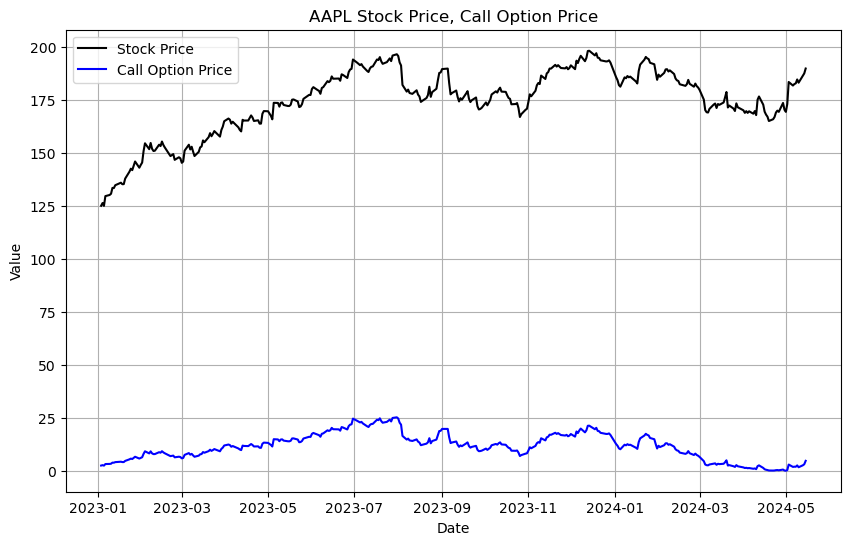

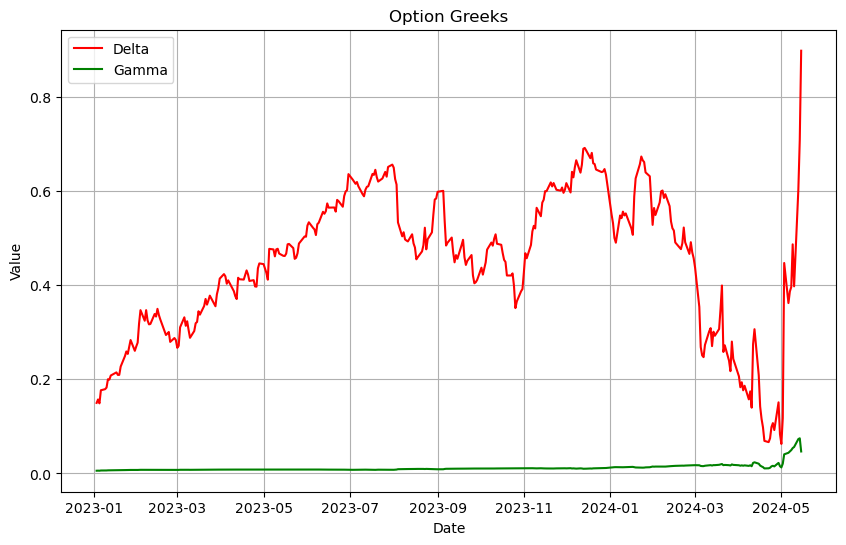

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.048050   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.327507   
2023-01-05  127.129997  127.769997  124.760002  125.019997  123.998451   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.560852   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.086548   
...                ...         ...         ...         ...         ...   
2024-05-09  182.559998  184.660004  182.110001  184.570007  184.320007   
2024-05-10  184.899994  185.089996  182.130005  183.050003  183.050003   
2024-05-13  185.440002  187.100006  184.619995  186.279999  186.279999   
2024-05-14  187.509995  188.300003  186.289993  187.429993  187.429993   
2024-05-15  187.910004  190.649994  187.369995  189.720001  189.720001   

              Volume  
Date          

,count,mean,std,min,25%,50%,75%,max
Open,344.0,174.102064,15.831171,126.010002,167.750000,176.385002,185.932499,198.020004
High,344.0,175.669012,15.588317,127.769997,169.057499,177.809998,187.157505,199.619995
Low,344.0,172.772267,15.793692,124.169998,166.465004,174.810005,184.290005,197.000000
Close,344.0,174.313401,15.649421,125.019997,167.742500,176.340004,186.054996,198.110001
Adj Close,344.0,173.591732,15.789978,123.998451,167.170162,175.763321,185.497116,197.589523
Volume,344.0,59.985288,18.751931,24.048300,48.088450,55.077500,66.854150,163.224100


In [369]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

# Function to calculate Black-Scholes Greeks
def black_scholes_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d1)
    return call_price, delta, gamma, theta

# Fetch historical stock prices for AAPL
stock_data = yf.download('AAPL', start='2023-01-01', end='2024-05-16')

stock_data.info()
# Extract the 'Close' prices and convert index to datetime
stock_prices = stock_data['Close']
stock_volu = stock_data['Volume']
stock_prices.index = pd.to_datetime(stock_prices.index)

# Define option parameters
K = 185  # Strike price of the option
r = 0.01  # Risk-free interest rate
sigma = 0.2702  # Volatility of the underlying stock

# Initialize lists to store values
option_prices = []
delta_values = []
gamma_values = []
theta_values = []

for date in stock_prices.index:
    # Calculate time to expiration dynamically
    T = (pd.Timestamp('2024-05-17') - date).days / 365
    
    # Get the corresponding stock price
    S = stock_prices.loc[date]
    
    # Calculate option price and Greeks
    call_price, delta, gamma, theta = black_scholes_greeks(S, K, T, r, sigma)
    
    # Append to lists
    option_prices.append(call_price)
    delta_values.append(delta)
    gamma_values.append(gamma)
    theta_values.append(theta)

# Plot stock prices, option price, and Greeks on the same time axis
plt.figure(figsize=(10, 6))
plt.plot(stock_prices.index, stock_prices.values, label='Stock Price', color='black')
plt.plot(stock_prices.index, option_prices, label='Call Option Price', color='blue')
plt.title('AAPL Stock Price, Call Option Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(stock_prices.index, delta_values, label='Delta', color='red')
plt.plot(stock_prices.index, gamma_values, label='Gamma', color='green')
#plt.plot(stock_prices.index, theta_values, label='Theta', color='orange')

plt.title('Option Greeks')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


stock_data['Volume'] = stock_data['Volume'] / 1000000
print(stock_data)
stock_data.describe().T



In [370]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

maturity_date = pd.Timestamp('2024-05-17')


opp = pd.DataFrame({'OPrice': option_prices})
delt = pd.DataFrame({'Delta': delta_values})
gam = pd.DataFrame({'Gamma': gamma_values})
thet = pd.DataFrame({'Theta': theta_values})


df = pd.concat([ opp, delt, gam, thet], axis=1)
df.set_index(stock_data.index, inplace=True)
df['volu']=stock_data['Volume']
df['precio']=stock_data['Close']
df['time_to_maturity'] = (maturity_date - df.index).days / 365


df['lggamma'] = df['Gamma'].shift(1)
df['lgdelta'] = df['Delta'].shift(1)
df['lgprice'] = df['OPrice'].shift(1)
df['lgtheta'] = df['Theta'].shift(1)
df['lgvolu'] = df['volu'].shift(1)
df['lgprix'] = df['precio'].shift(1)
    
df['lggamma2'] = df['Gamma'].shift(2)
df['lgdelta2'] = df['Delta'].shift(2)
df['lgprice2'] = df['OPrice'].shift(2)
df['lgtheta2'] = df['Theta'].shift(2)
df['lgvolu2'] = df['volu'].shift(2)
df['lgprix2'] = df['precio'].shift(2)

#y = df['Gamma']
#df['invlagt'] = 1 / df['time_to_maturity']
#df['invlagp'] = 1 / df['lgprice']
#df['interac'] = df['invlagp']*df['invlagt']
#df.to_excel('output5.xlsx', index=True)
#df = df.drop(df.columns[:12], axis=1)

print(df)


              OPrice     Delta     Gamma      Theta      volu      precio  \
Date                                                                        
2023-01-03  2.687546  0.149992  0.005895  -3.639647  112.1175  125.070000   
2023-01-04  2.875884  0.157345  0.006028  -3.800794   89.1136  126.360001   
2023-01-05  2.660774  0.149026  0.005883  -3.628790   80.9627  125.019997   
2023-01-06  3.399034  0.176841  0.006349  -4.216904   87.7547  129.619995   
2023-01-09  3.459504  0.179174  0.006395  -4.281511   70.7908  130.149994   
...              ...       ...       ...        ...       ...         ...   
2024-05-09  2.757751  0.486960  0.054005 -68.058395   48.9830  184.570007   
2024-05-10  1.894909  0.397682  0.056318 -69.620854   50.7595  183.050003   
2024-05-13  2.808687  0.603255  0.073163 -93.791845   72.0448  186.279999   
2024-05-14  3.297643  0.708264  0.074763 -97.184819   52.3936  187.429993   
2024-05-15  4.914846  0.898375  0.046796 -63.148245   70.4000  189.720001   

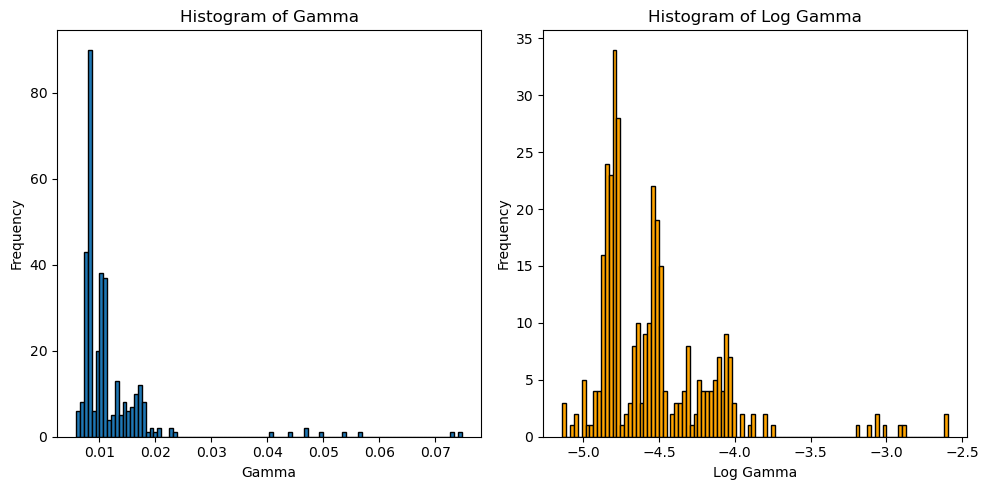

In [371]:
df['lngamma'] = np.log(df['Gamma'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot histogram for the 'gamma' column
axes[0].hist(df['Gamma'], bins=100, edgecolor='black')
axes[0].set_title('Histogram of Gamma')
axes[0].set_xlabel('Gamma')
axes[0].set_ylabel('Frequency')

# Plot histogram for the 'log_gamma' column
axes[1].hist(df['lngamma'], bins=100, edgecolor='black', color='orange')  # Specify color if desired
axes[1].set_title('Histogram of Log Gamma')
axes[1].set_xlabel('Log Gamma')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

OPrice
Skew : 0.06


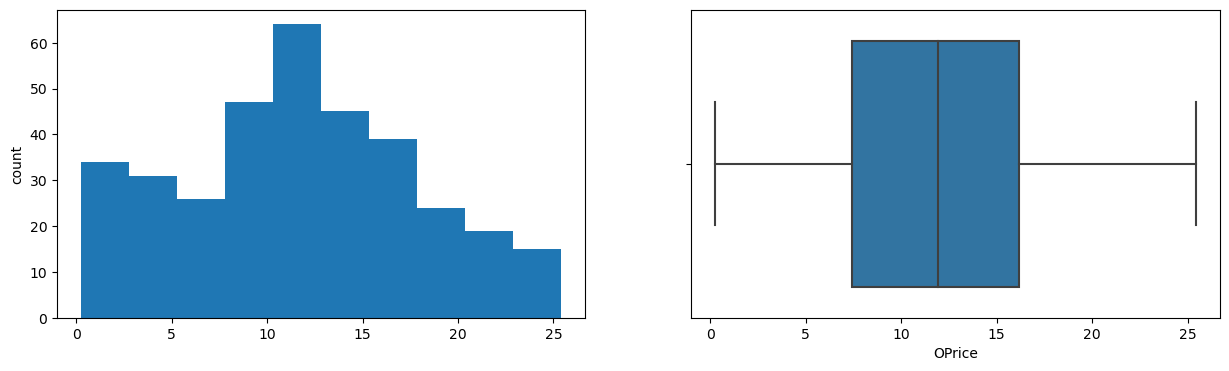

Delta
Skew : -0.44


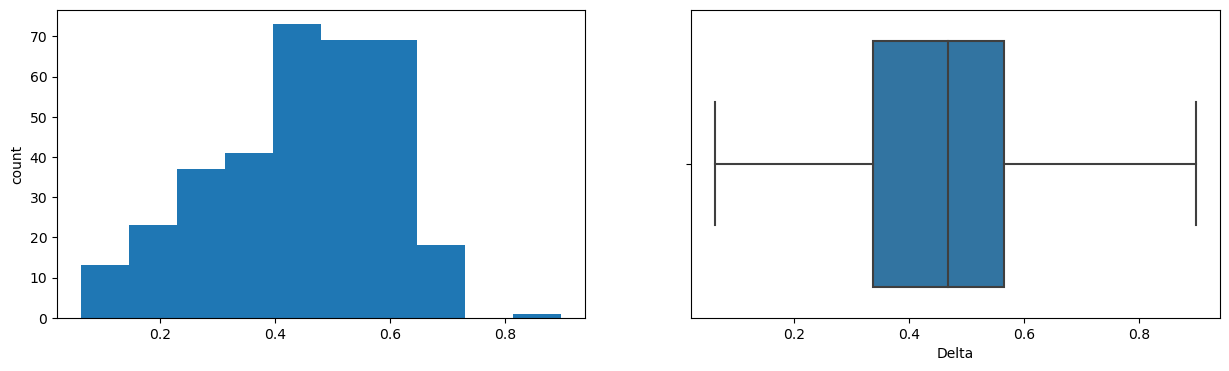

Gamma
Skew : 4.93


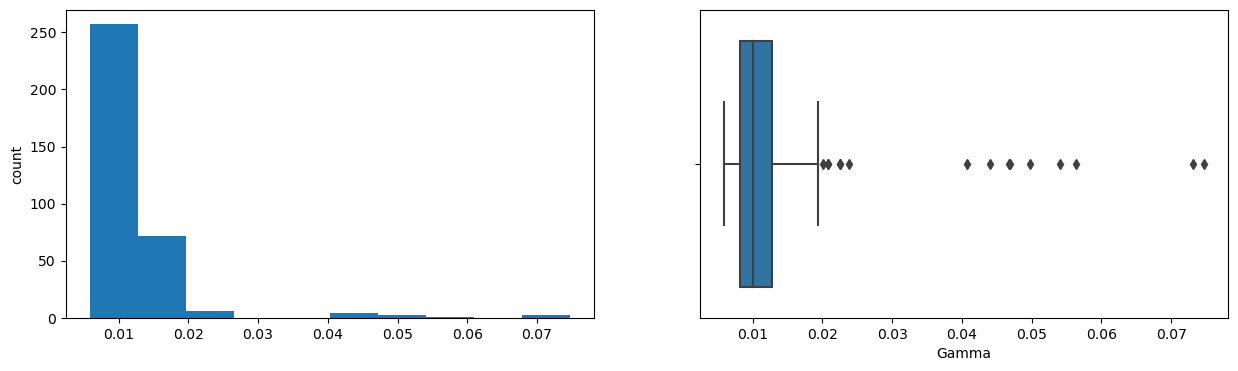

Theta
Skew : -4.78


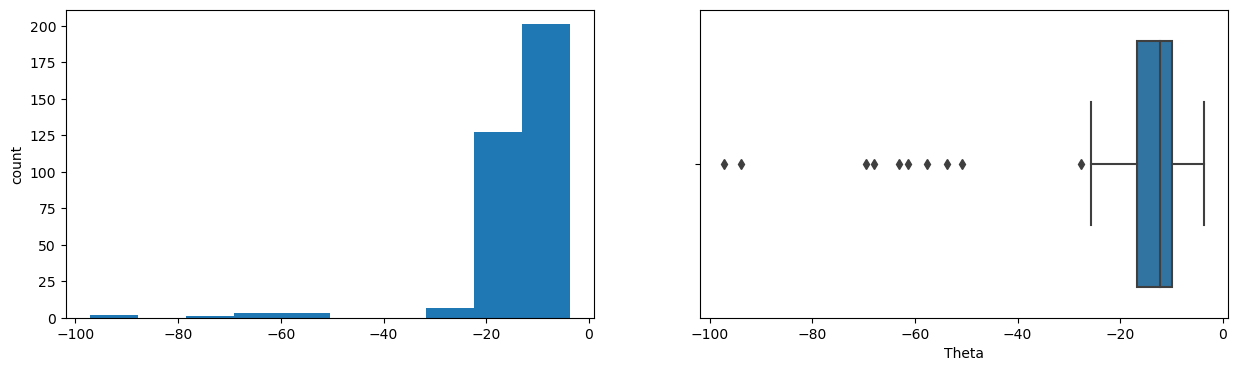

volu
Skew : 2.0


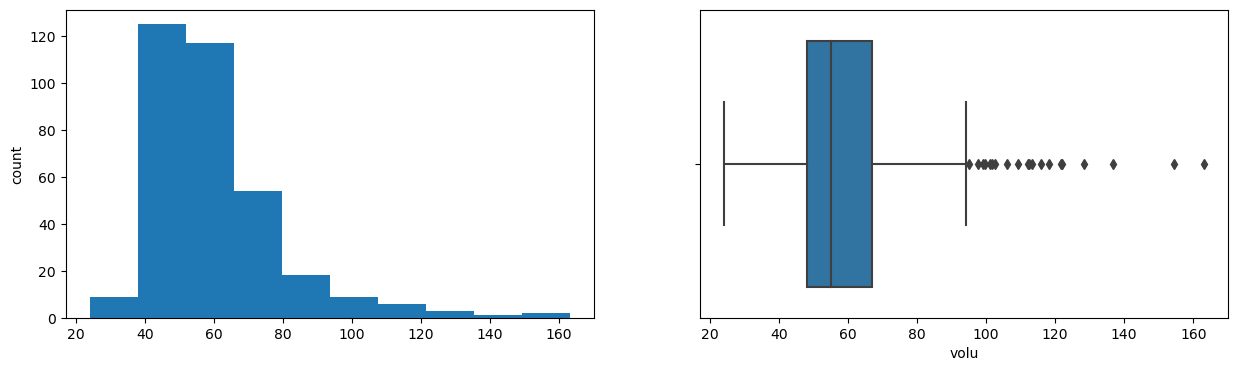

precio
Skew : -0.92


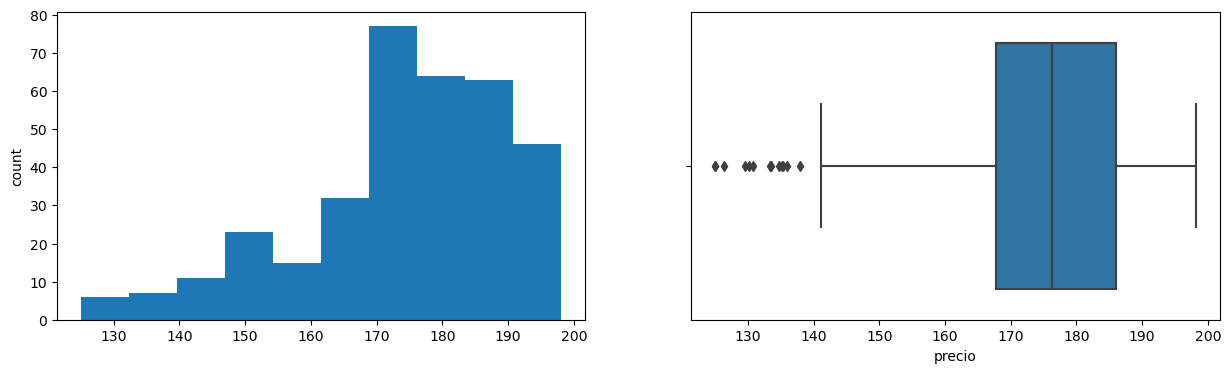

time_to_maturity
Skew : -0.01


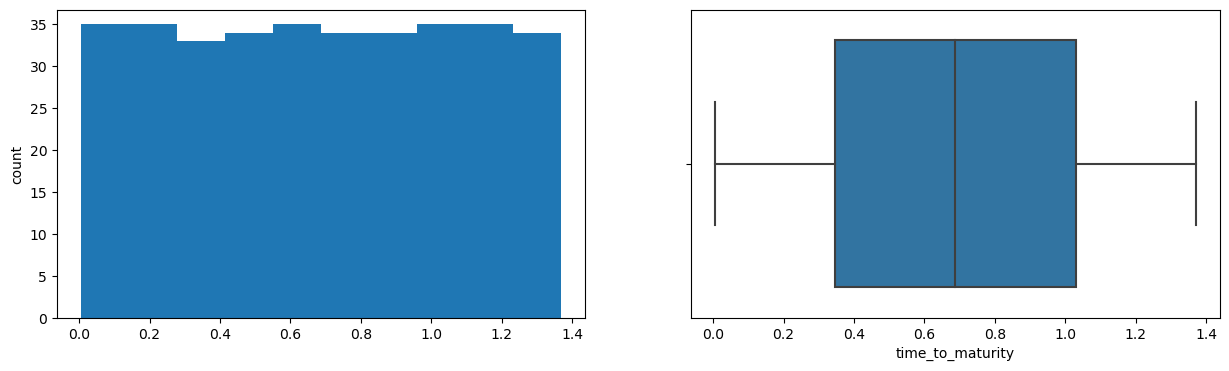

lggamma
Skew : 5.14


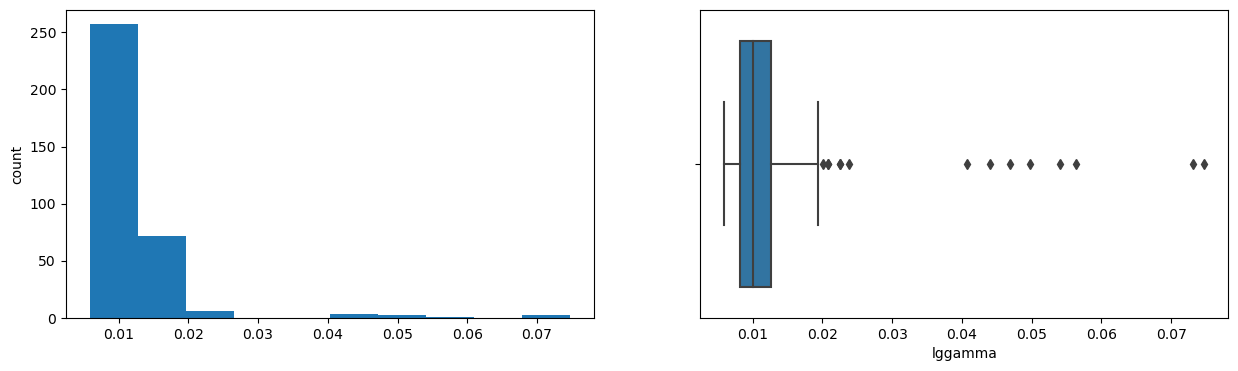

lgdelta
Skew : -0.51


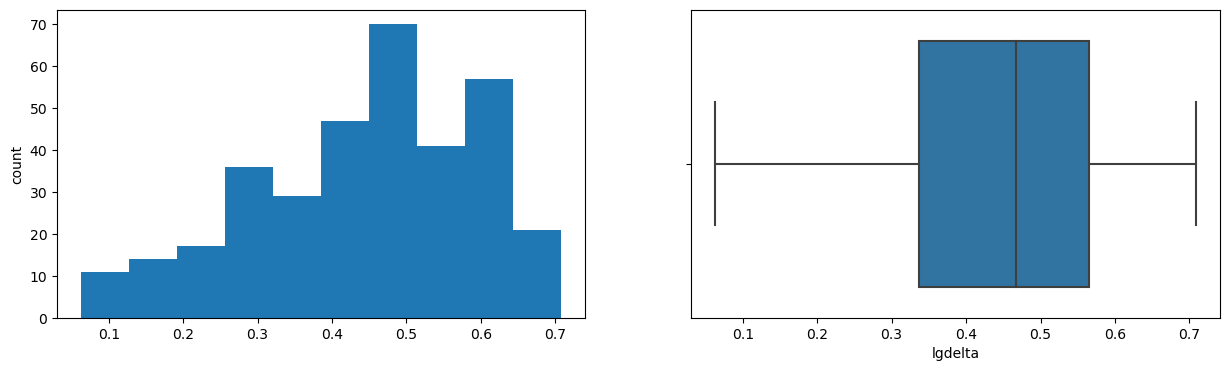

lgprice
Skew : 0.06


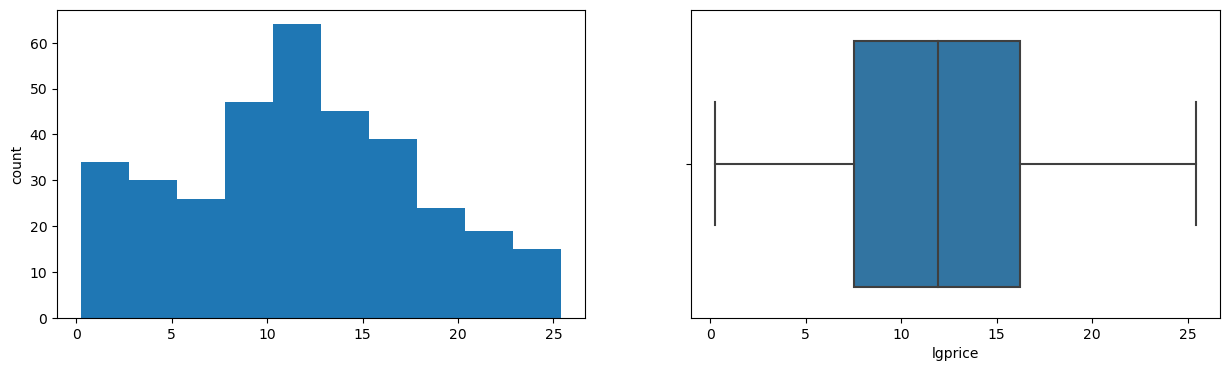

lgtheta
Skew : -4.98


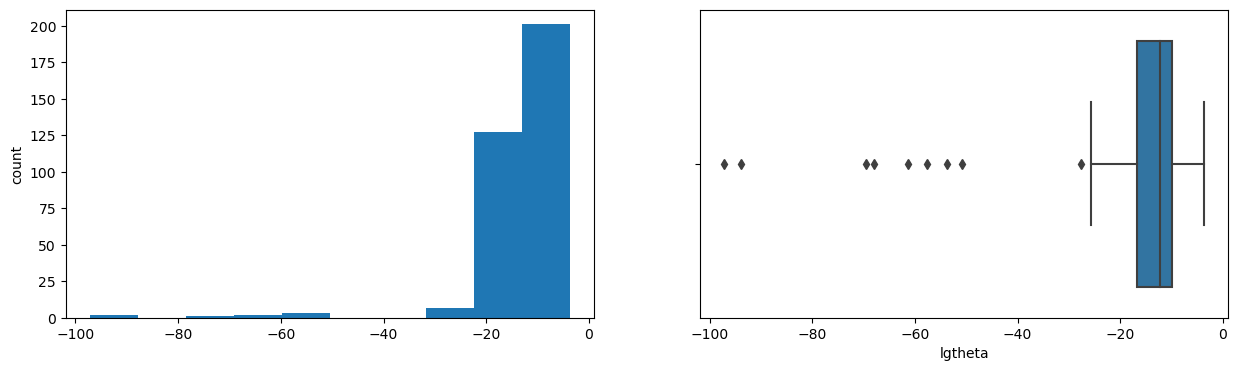

lgvolu
Skew : 2.0


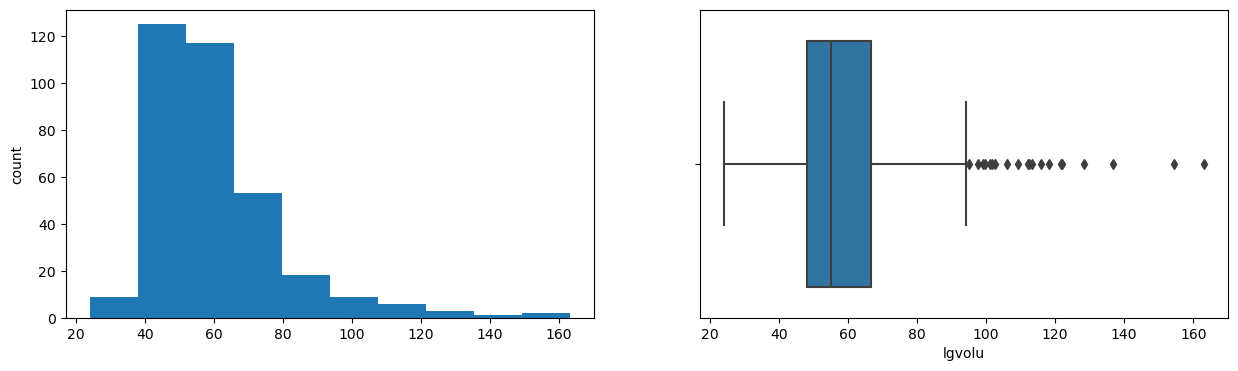

lgprix
Skew : -0.92


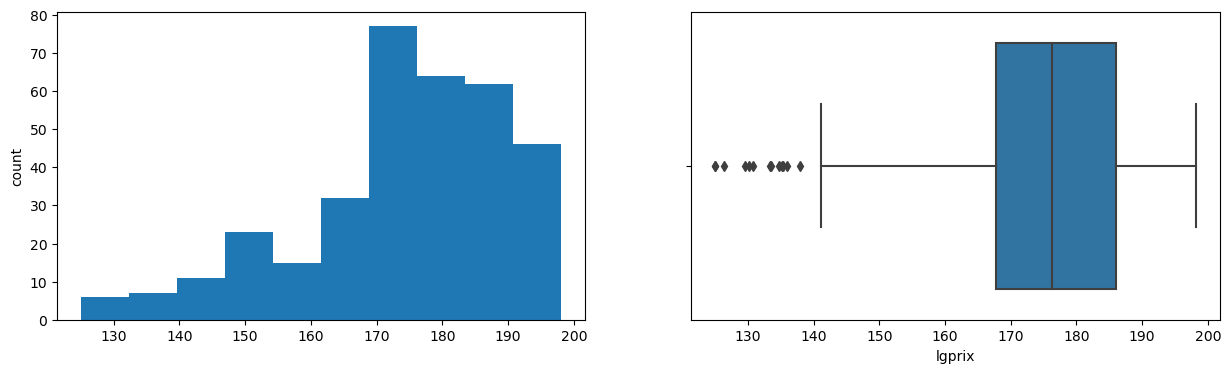

lggamma2
Skew : 4.98


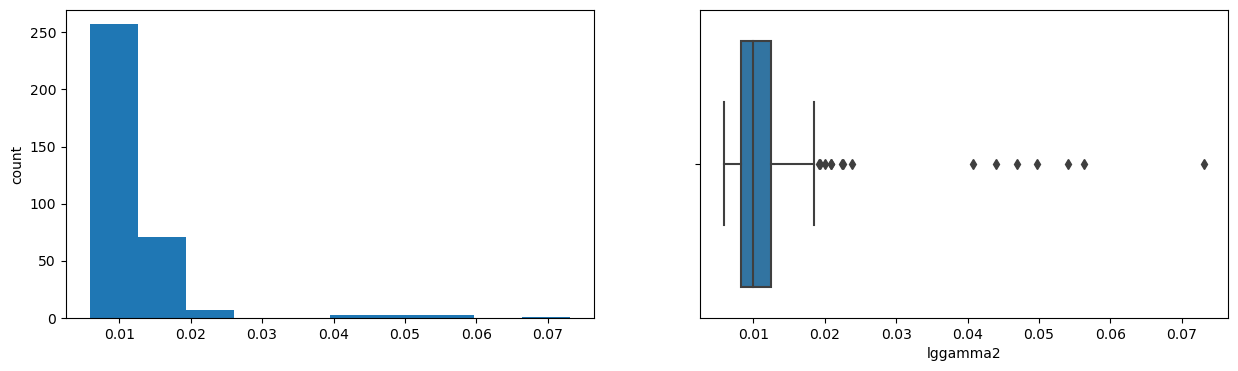

lgdelta2
Skew : -0.52


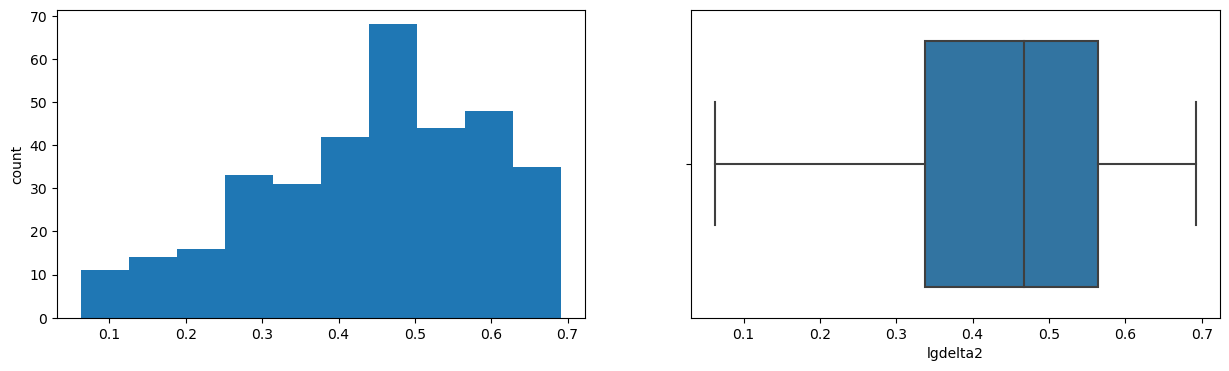

lgprice2
Skew : 0.05


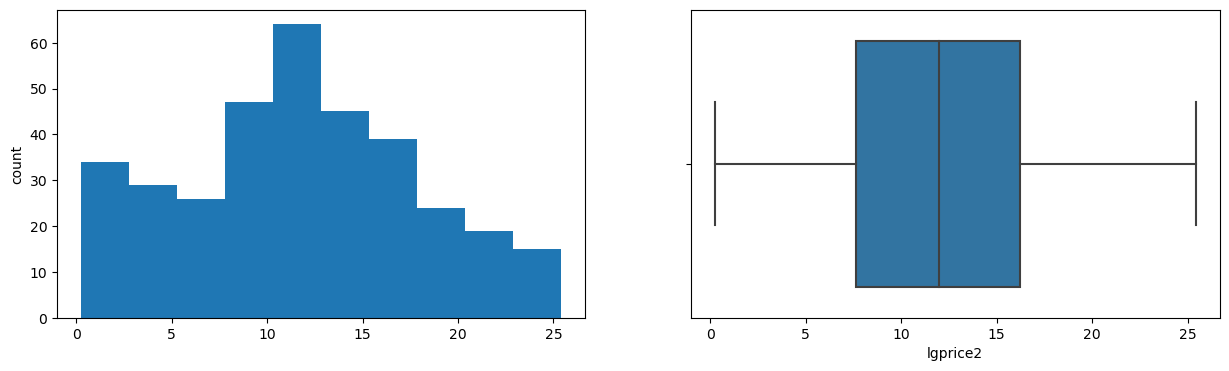

lgtheta2
Skew : -4.7


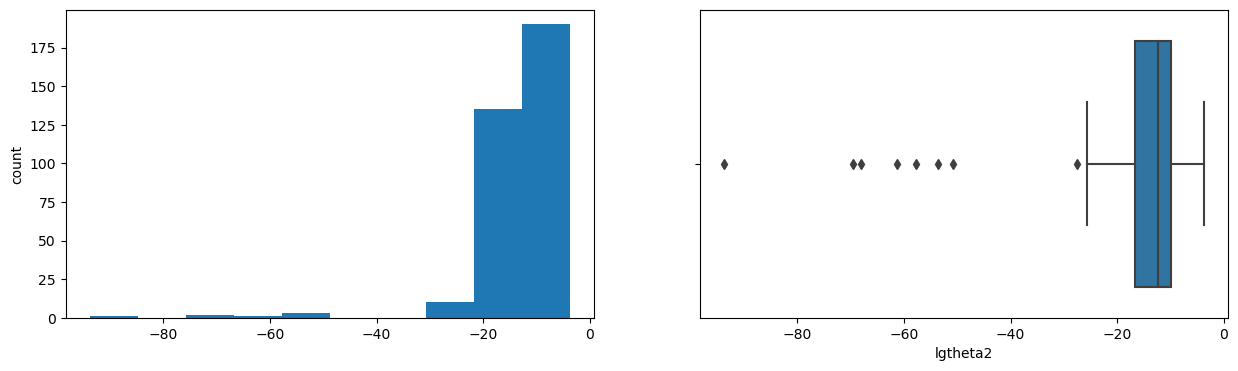

lgvolu2
Skew : 2.0


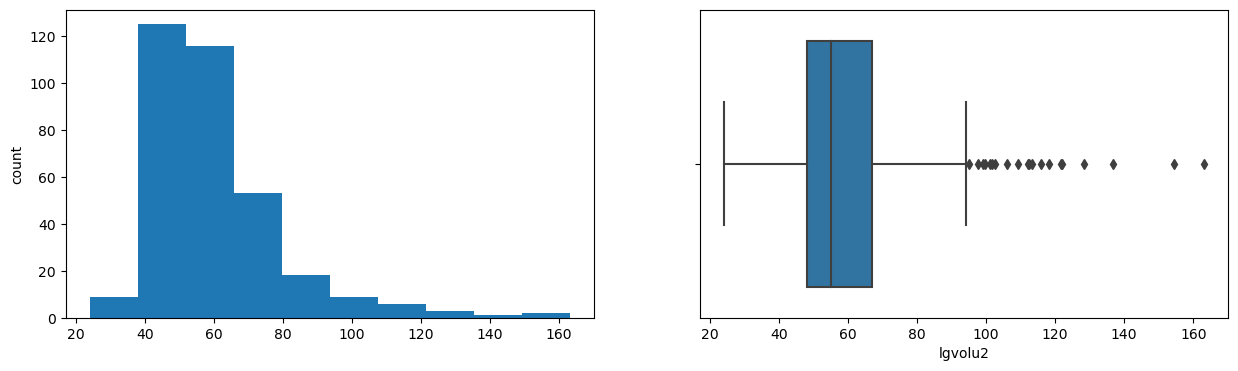

lgprix2
Skew : -0.91


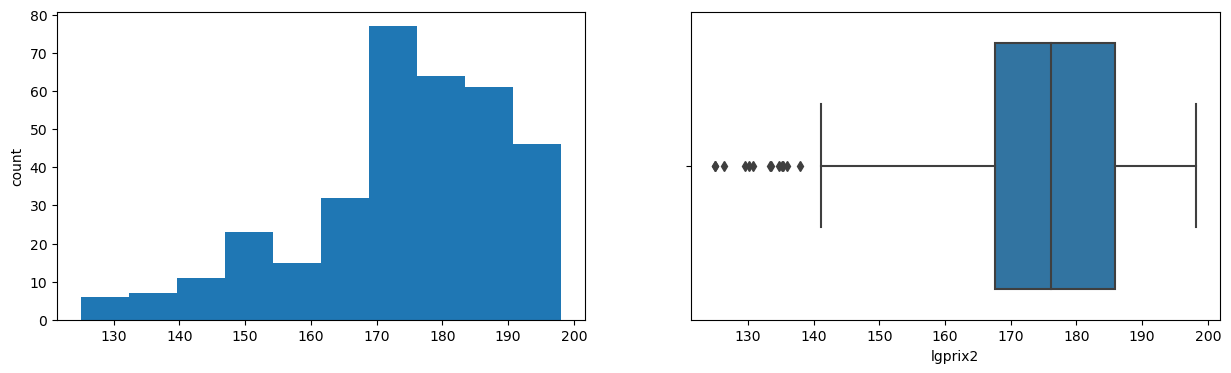

lngamma
Skew : 2.01


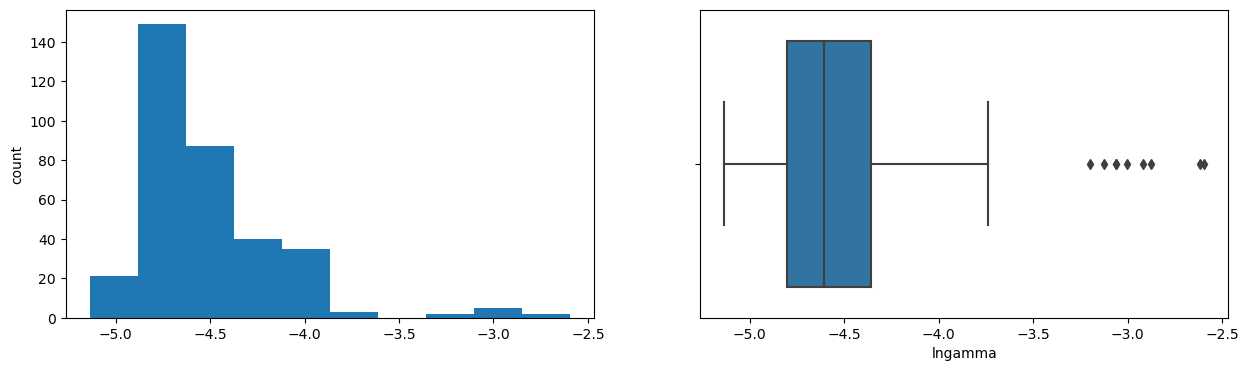

In [372]:
import seaborn as sns

cat_cols=df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

OPrice
Skew : 0.06


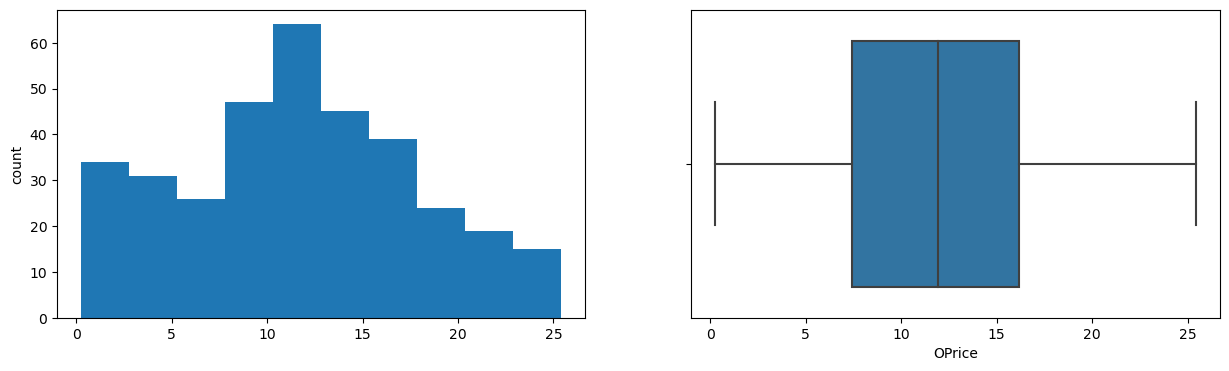

Delta
Skew : -0.44


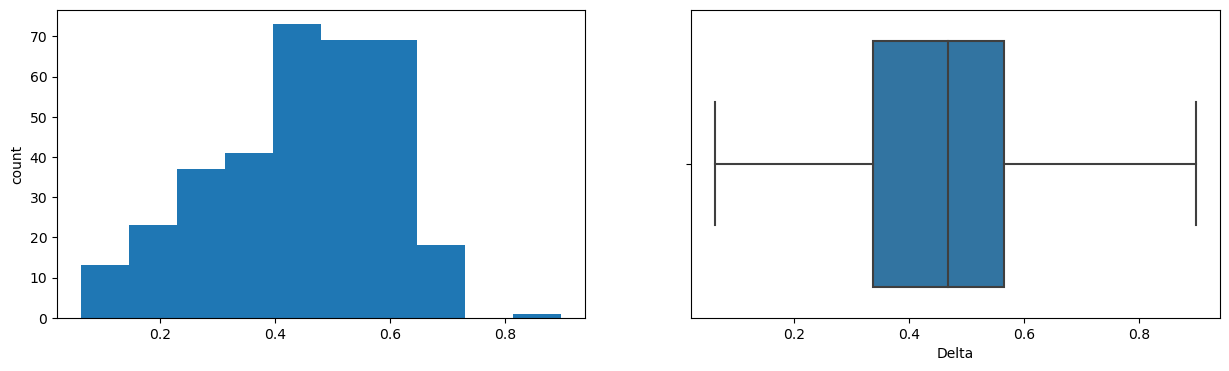

Gamma
Skew : 4.93


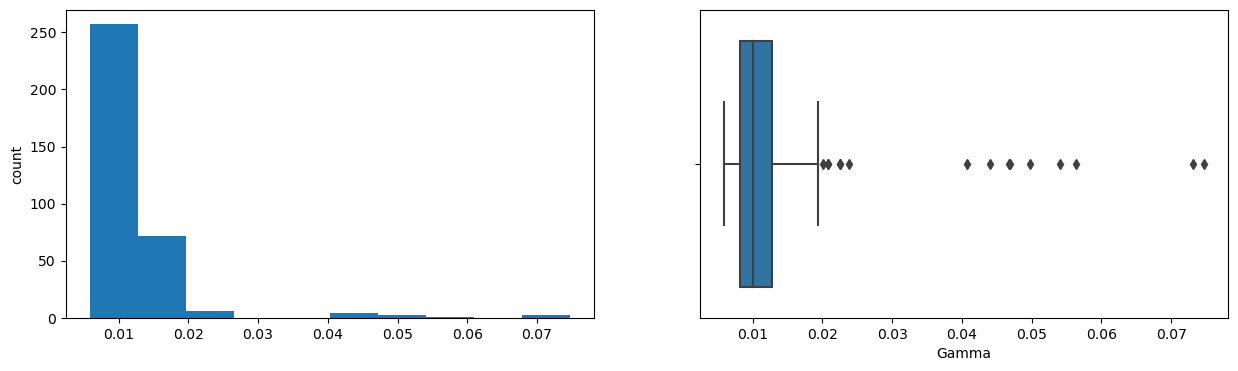

Theta
Skew : -4.78


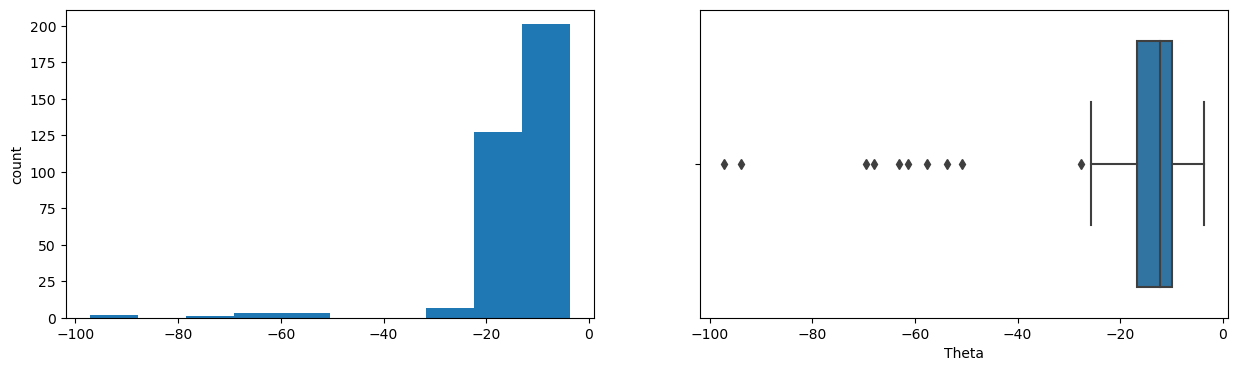

volu
Skew : 2.0


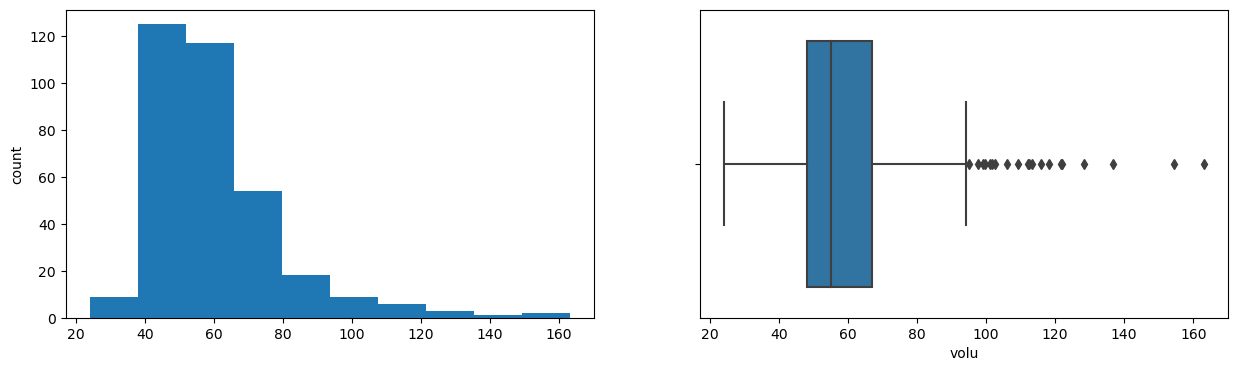

precio
Skew : -0.92


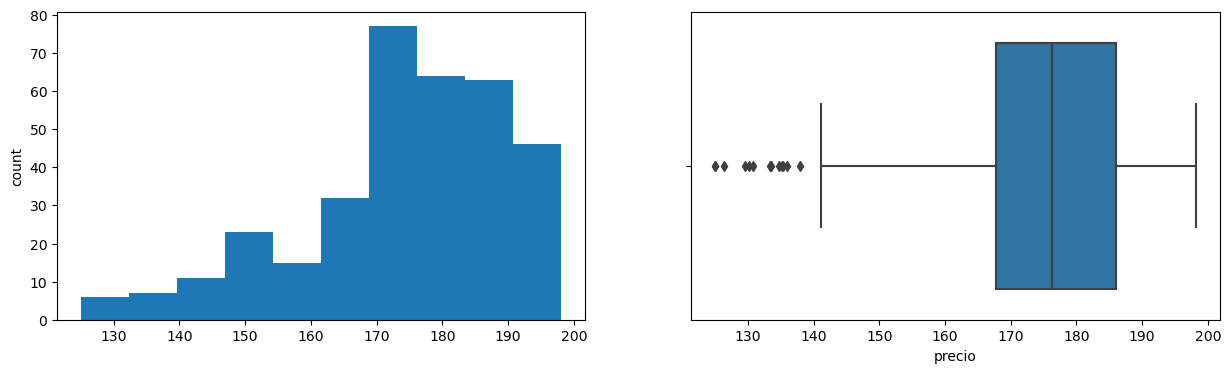

time_to_maturity
Skew : -0.01


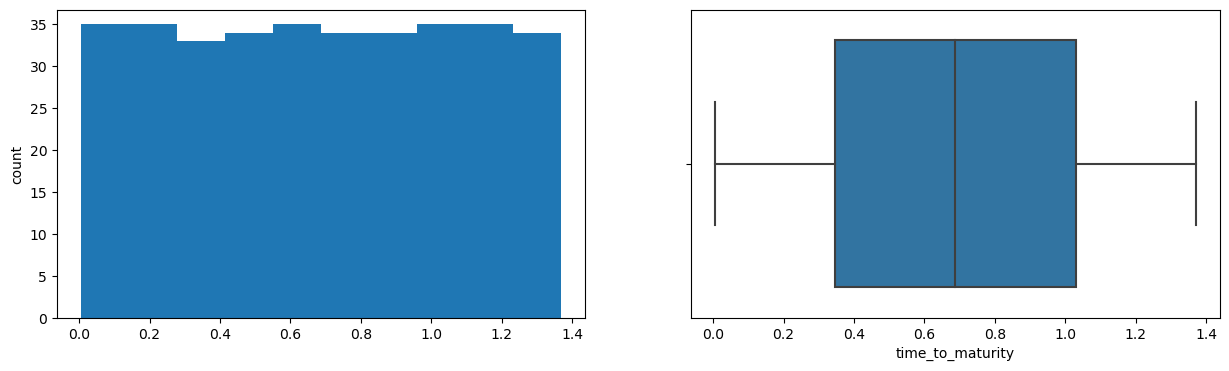

lggamma
Skew : 5.14


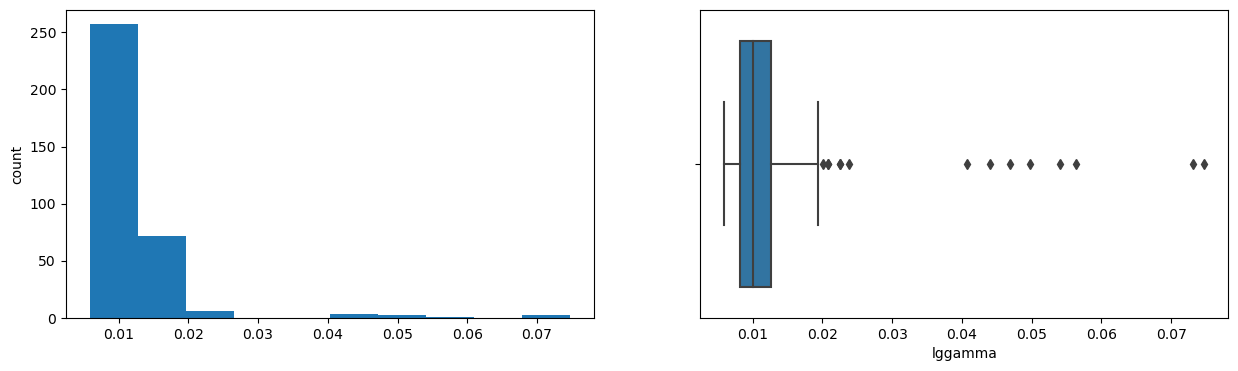

lgdelta
Skew : -0.51


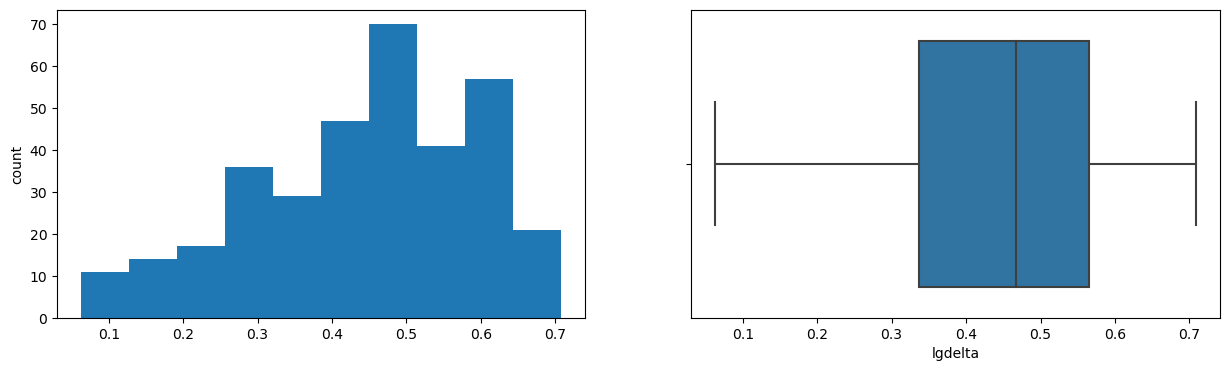

lgprice
Skew : 0.06


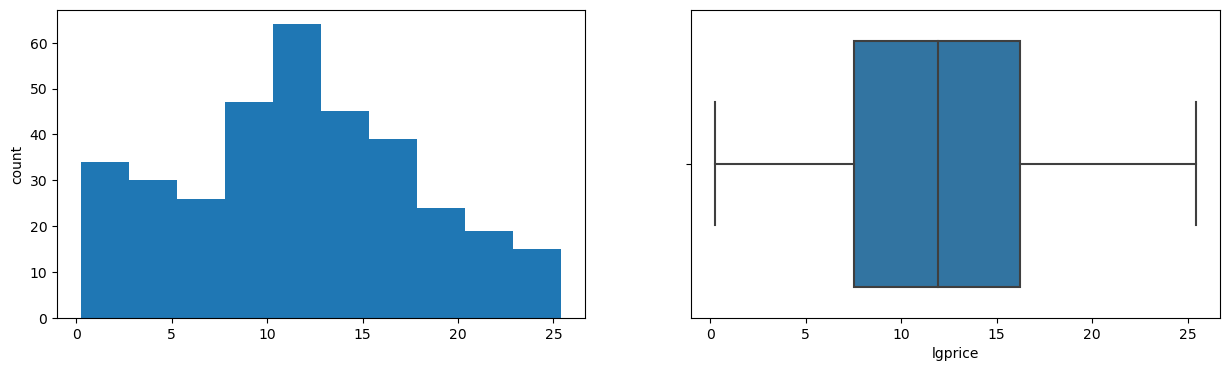

lgtheta
Skew : -4.98


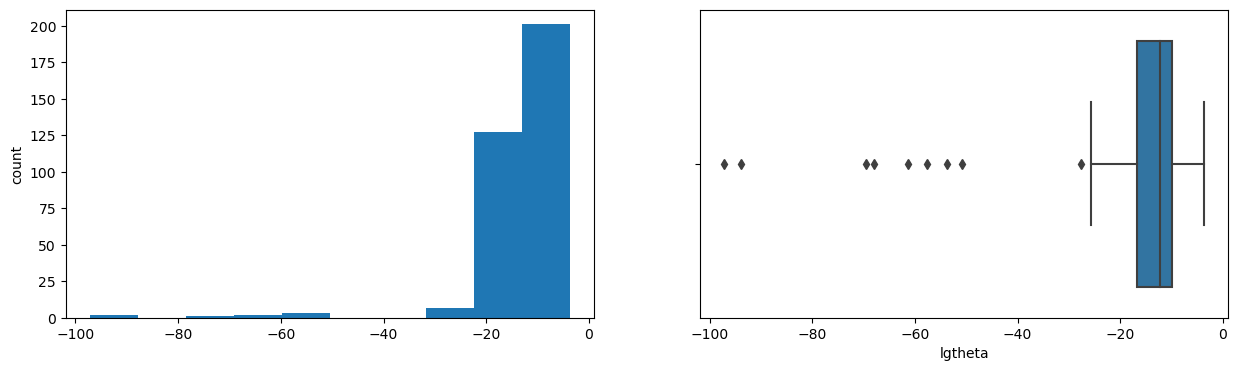

lgvolu
Skew : 2.0


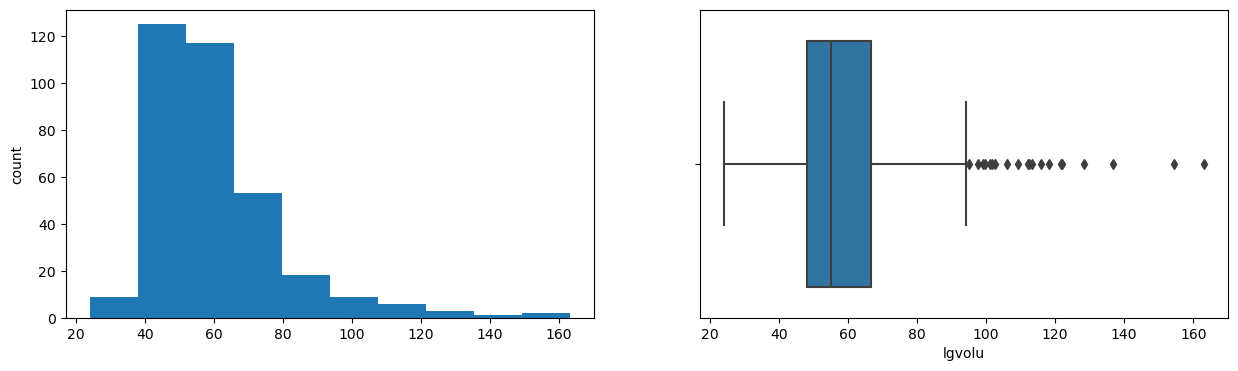

lgprix
Skew : -0.92


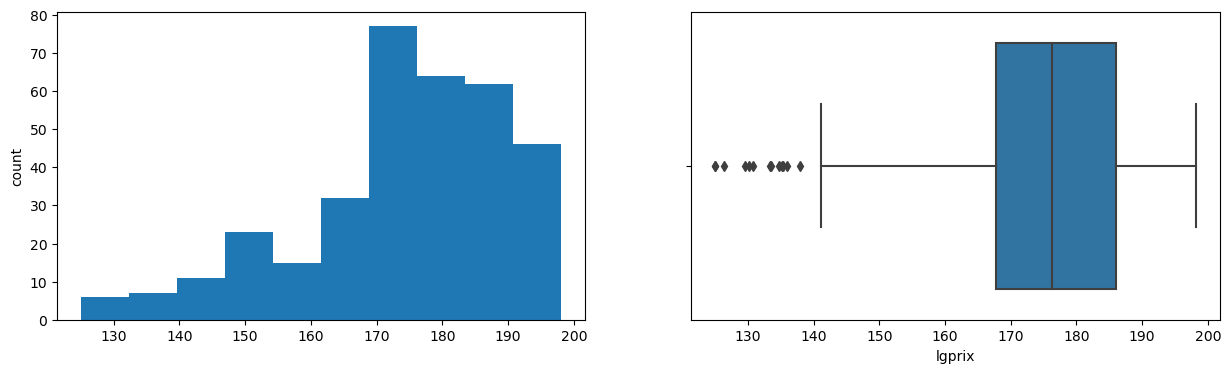

lggamma2
Skew : 4.98


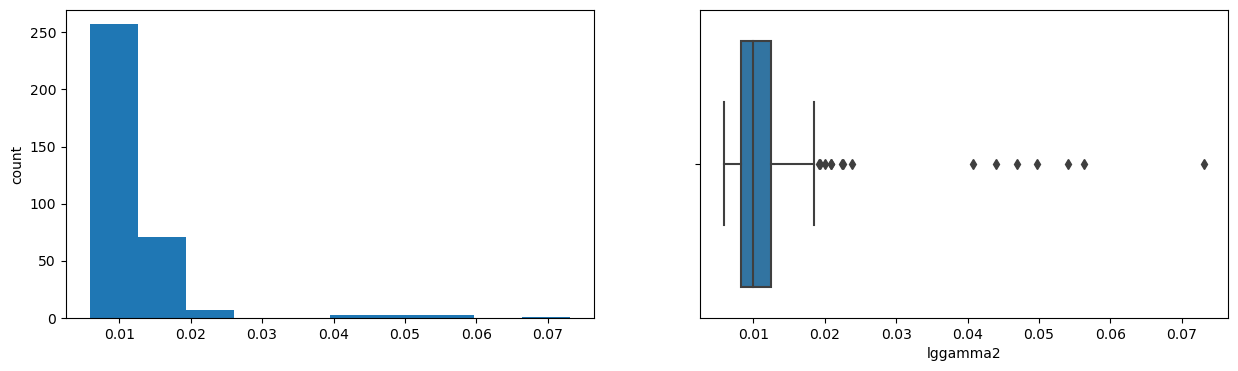

lgdelta2
Skew : -0.52


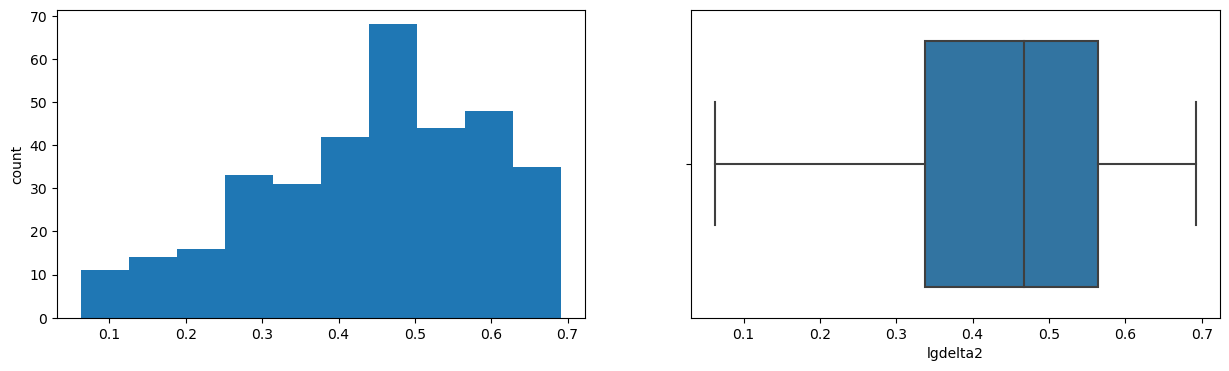

lgprice2
Skew : 0.05


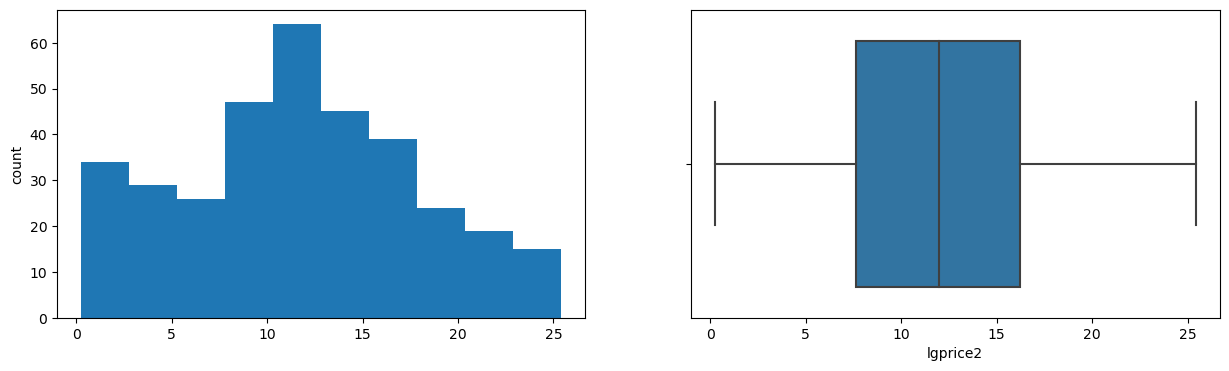

lgtheta2
Skew : -4.7


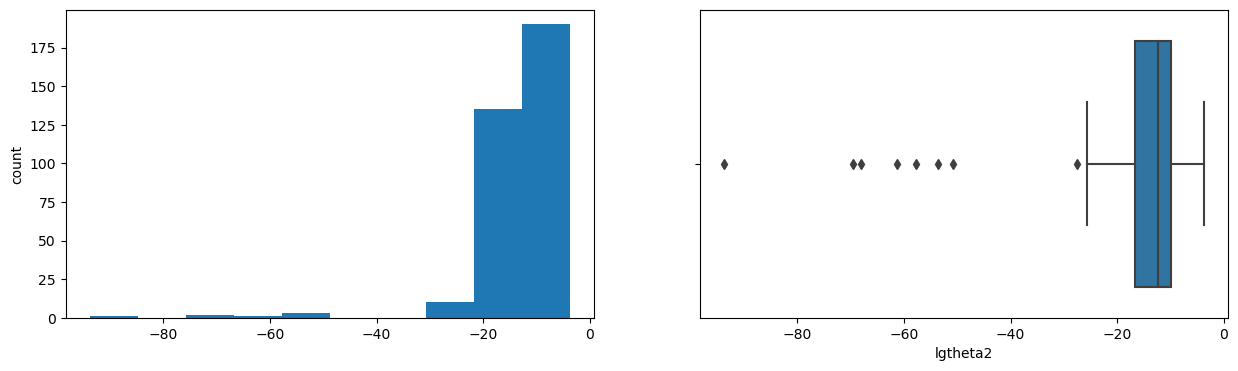

lgvolu2
Skew : 2.0


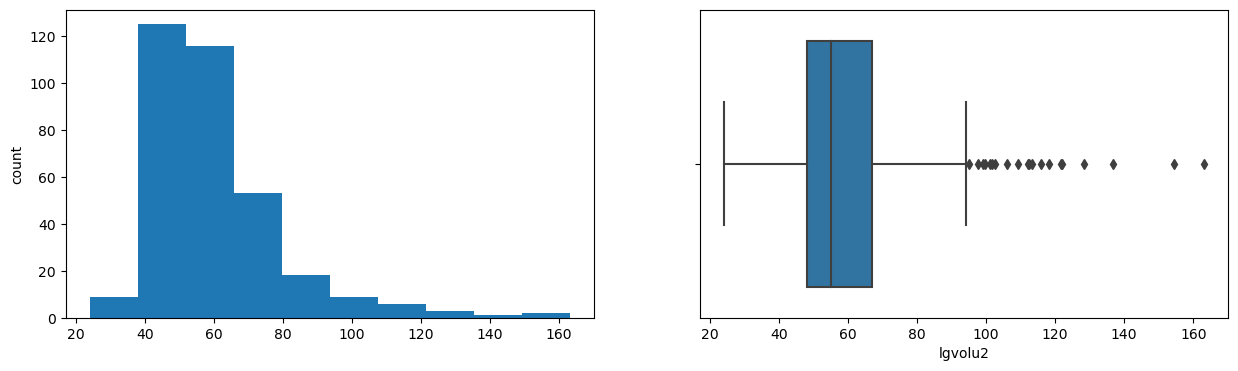

lgprix2
Skew : -0.91


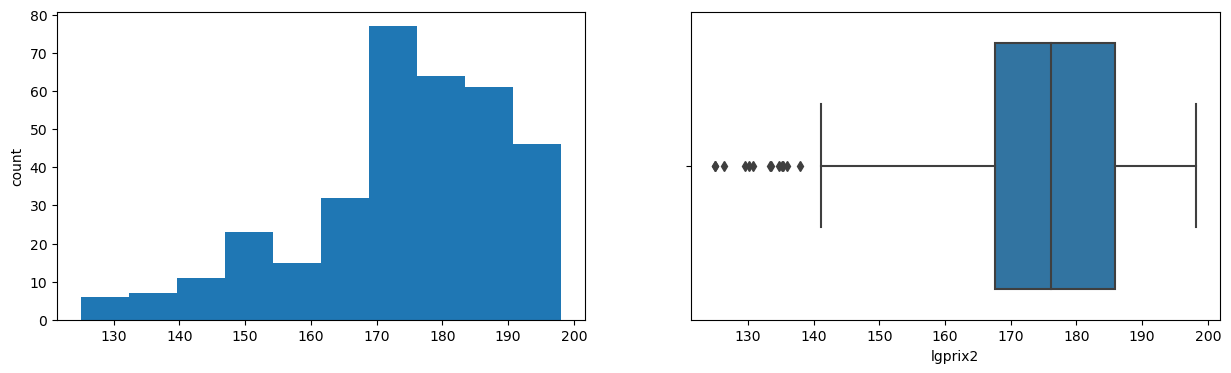

lngamma
Skew : 2.01


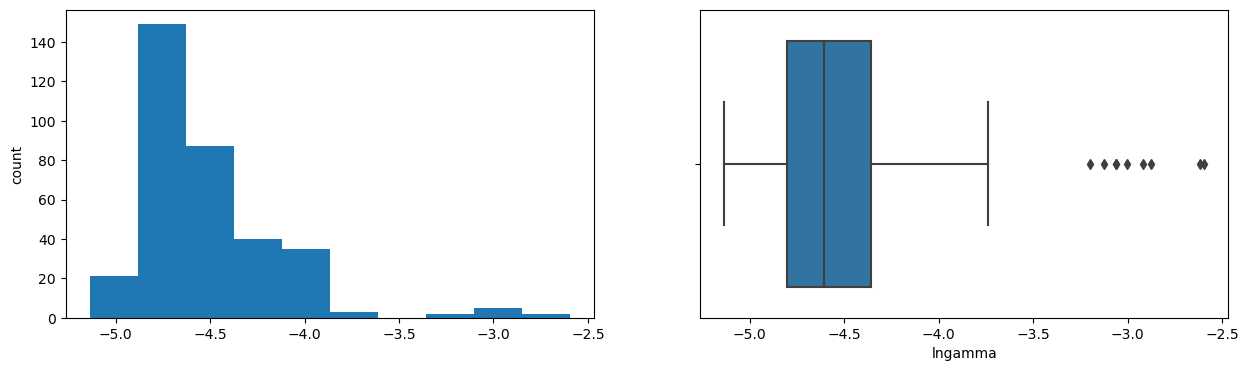

lnlggamma
Skew : 2.01


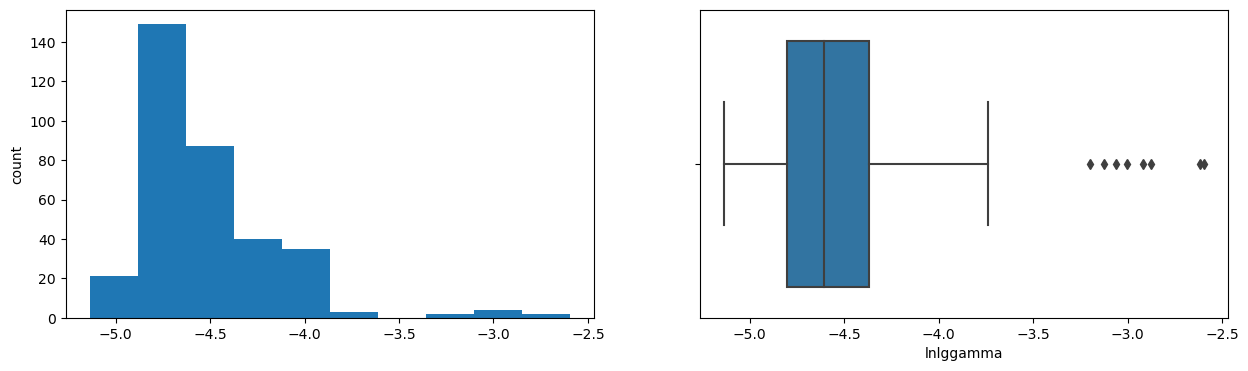

lnlgvolu
Skew : 0.8


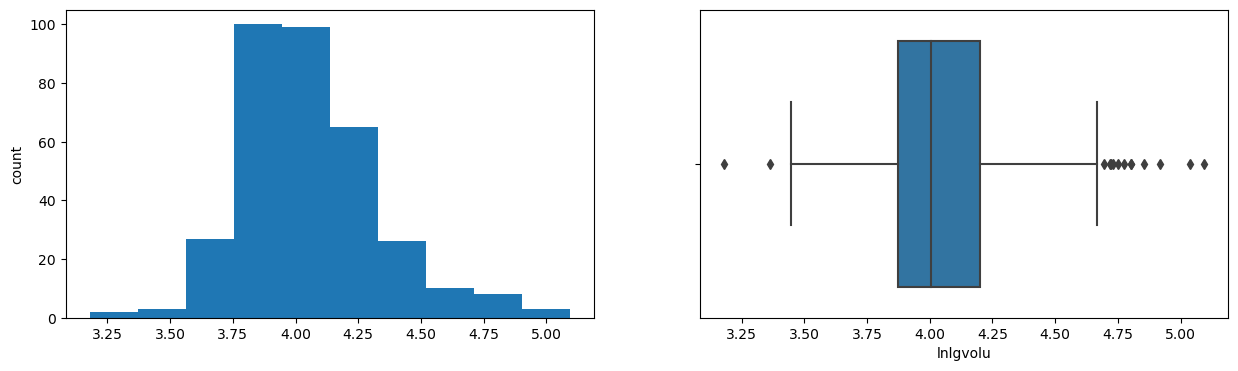

lnlggamma2
Skew : 1.87


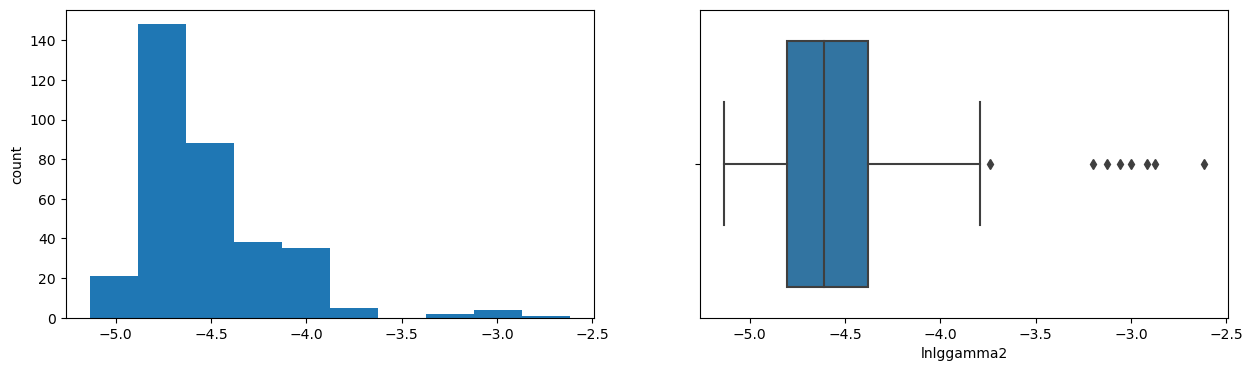

lnlgvolu2
Skew : 0.79


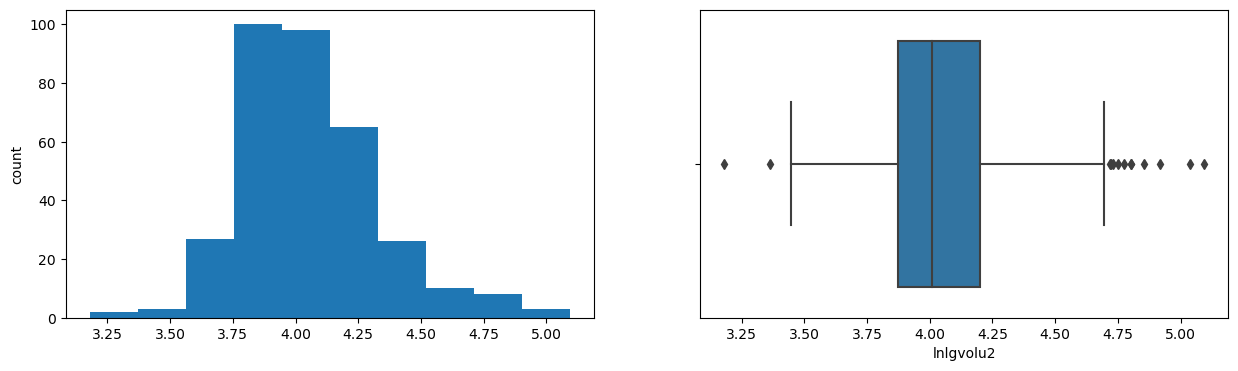

In [373]:
df['lnlggamma'] = np.log(df['lggamma'])
df['lnlgvolu'] = np.log(df['lgvolu'])
df['lnlggamma2'] = np.log(df['lggamma2'])
df['lnlgvolu2'] = np.log(df['lgvolu2'])

cat_cols=df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    print(col)
    print('Skew :', round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

In [374]:
#df.to_excel('output9.xlsx', index=True)
#sns.pairplot(data=df.drop(['OPrice', 'precio', 'Theta', 'Delta', 'volu'],axis=1))
#plt.show()


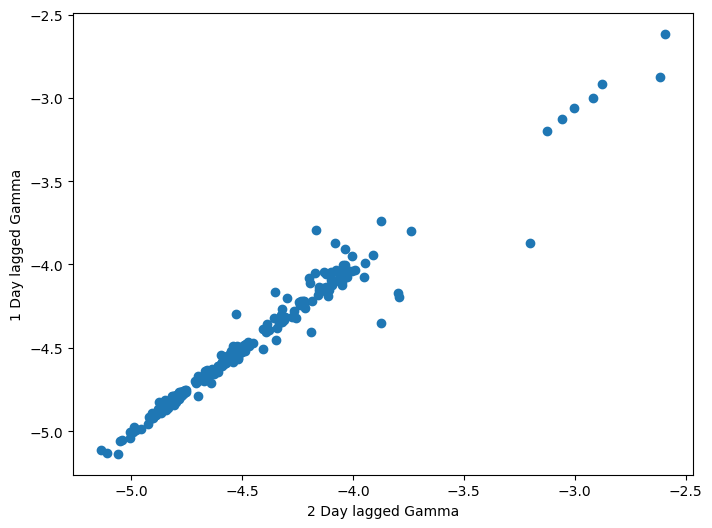

In [375]:
plt.figure(figsize=(8, 6))
plt.scatter(df['lnlggamma'], df['lnlggamma2'])
plt.xlabel('2 Day lagged Gamma')
plt.ylabel('1 Day lagged Gamma')
plt.show()

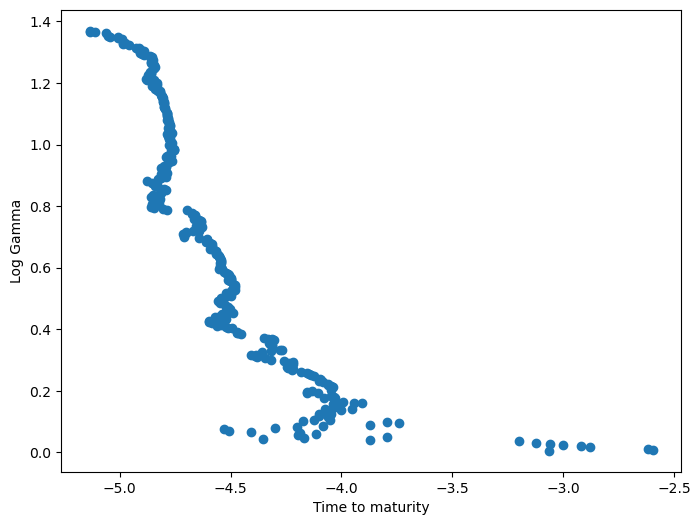

In [376]:
plt.figure(figsize=(8, 6))
plt.scatter(df['lngamma'], df['time_to_maturity'])
plt.xlabel('Time to maturity')
plt.ylabel('Log Gamma')
plt.show()

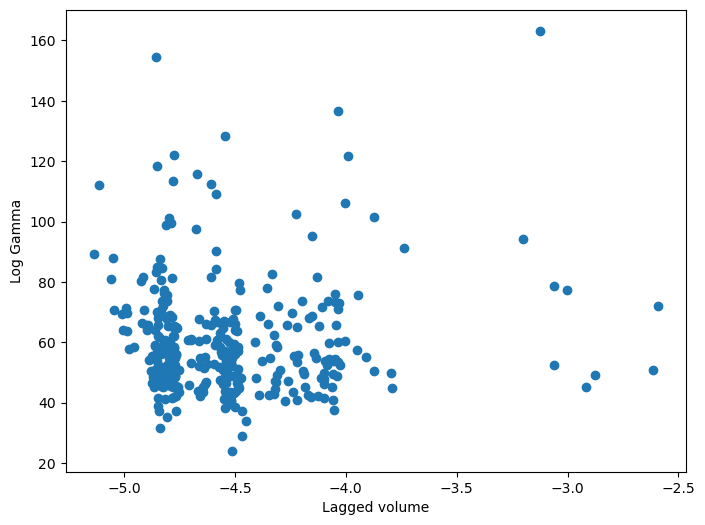

In [377]:
plt.figure(figsize=(8, 6))
plt.scatter(df['lngamma'], df['lgvolu'])
plt.xlabel('Lagged volume')
plt.ylabel('Log Gamma')
plt.show()

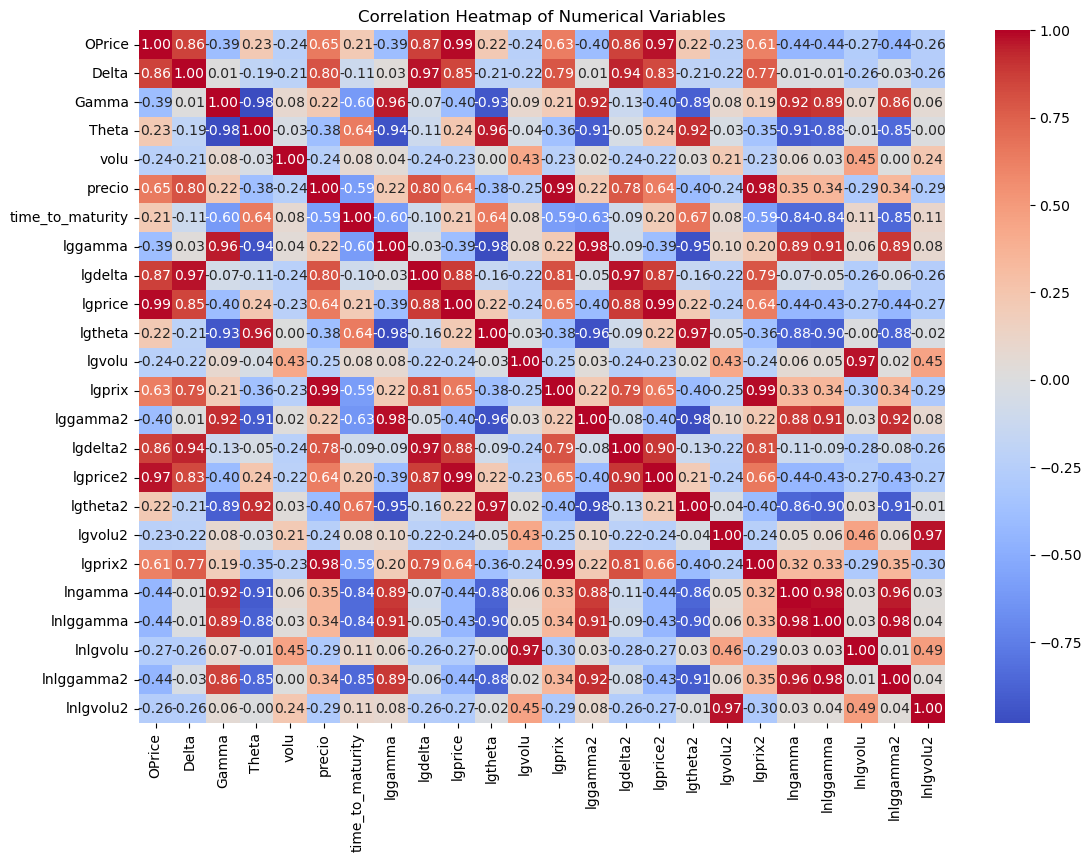

In [378]:
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(13, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

            lnlggamma       lnt   lgprice      lgprix   lgdelta    lgtheta  \
Date                                                                         
2023-01-05  -5.111279  0.310703  2.875884  126.360001  0.157345  -3.800794   
2023-01-06  -5.135618  0.308693  2.660774  125.019997  0.149026  -3.628790   
2023-01-09  -5.059400  0.302638  3.399034  129.619995  0.176841  -4.216904   
2023-01-10  -5.052189  0.300612  3.459504  130.149994  0.179174  -4.281511   
2023-01-11  -5.043927  0.298581  3.552925  130.729996  0.182549  -4.356107   
...               ...       ...       ...         ...       ...        ...   
2024-03-20  -3.944487 -1.839454  4.247019  176.080002  0.349859 -22.558682   
2024-03-21  -3.908576 -1.856846  5.153162  178.669998  0.399506 -24.124713   
2024-03-22  -4.036169 -1.874546  2.702436  171.369995  0.258258 -19.414602   
2024-03-25  -4.005602 -1.929605  2.889689  172.279999  0.272372 -20.236406   
2024-03-26  -4.036412 -1.948654  2.361578  170.850006  0.239714 

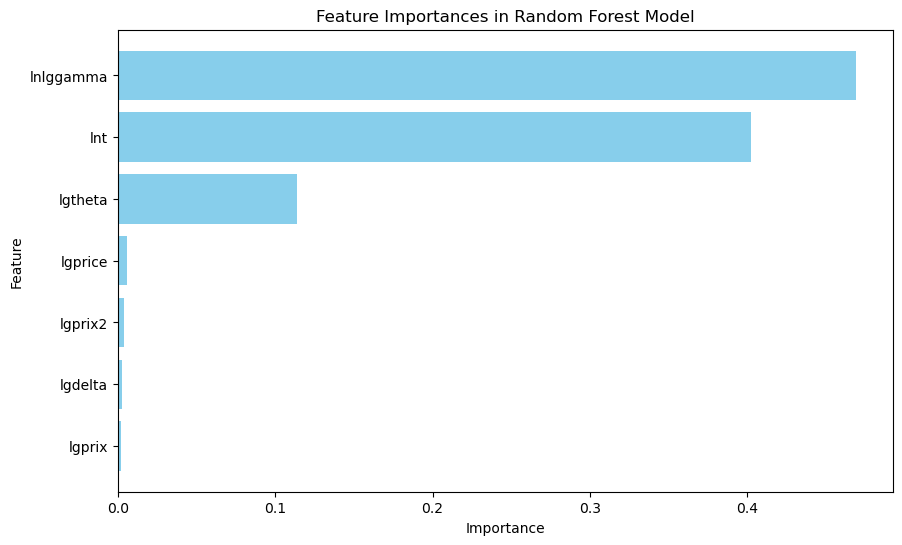

Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 0.01}
Best Model Mean Squared Error: 0.07666992212725529
Best Model R² Score: 0.7450181849662333
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
OH MINOT
XGBoost Mean Squared Error: 0.32122627883046473
XGBoost R² Score: -0.06830497984316786
Initial model AIC: -1492.5789160040617, BIC: -1462.7641340233642, R²: 0.8256001217064907

Best model results after removing one feature:
Best AIC: Remove lgprice, AIC: -1494.5616482315568, BIC: -1468.4737139984463, R²: 0.8293624290527941
Best BIC: Remove lgprice, AIC: -1494.5616482315568, BIC: -1468.4737139984463, R²: 0.8293624290527941
Best R²: Remove lgtheta, AIC: -1493.5727050764167, BIC: -1467.4847708433063, R²: 0.8447969508292443


In [379]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.svm import SVR
import statsmodels.api as sm



df = df.dropna()
df['lnt'] = np.log(df['time_to_maturity'])
X = df[['lnlggamma', 'lnt', 'lgprice', 'lgprix', 'lgdelta', 'lgtheta', 'lgprix2']]
y = df['lngamma']
df.to_excel('output10.xlsx', index=True)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n = len(X)
split_index = int(n * 0.9)
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(X_train,y_train,X_test, y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random forest mean Squared Error: {mse}")
print(f"Random forest R² Score: {r2}")

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5]
}

# Initialize Grid Search with SVR
grid_search = GridSearchCV(SVR(kernel='linear'), param_grid, cv=5, scoring='r2')

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model
svr_best = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = svr_best.predict(X_test_scaled)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model Mean Squared Error: {mse_best}")
print(f"Best Model R² Score: {r2_best}")

# Initialize XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the model with the best parameters
best_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Mean Squared Error: {mse}")
print(f"XGBoost R² Score: {r2}")




# Function to fit a model and return AIC, BIC, and R²
def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    aic = model_sm.aic
    bic = model_sm.bic
    return aic, bic, r2

# Initial model with all features
initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

# Evaluate models by removing one feature at a time
results = []
for feature in X.columns:
    X_train_reduced = X_train.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])
    aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
    results.append((feature, aic, bic, r2))

# Find the best model based on AIC, BIC, and R²
best_aic = min(results, key=lambda x: x[1])
best_bic = min(results, key=lambda x: x[2])
best_r2 = max(results, key=lambda x: x[3])

print("\nBest model results after removing one feature:")
print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")

#X = X.drop(columns=['lgdelta'])


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X = X.drop(columns=['lgprice'])
X_train = X_train.drop(columns=['lgprice'])
X_test = X_test.drop(columns=['lgprice'])
print(X_train, X_test)

# Function to fit a model and return AIC, BIC, and R²
def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    aic = model_sm.aic
    bic = model_sm.bic
    return aic, bic, r2

# Initial model with all features
initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

# Evaluate models by removing one feature at a time
results = []
for feature in X.columns:
    X_train_reduced = X_train.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])
    aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
    results.append((feature, aic, bic, r2))

# Find the best model based on AIC, BIC, and R²
best_aic = min(results, key=lambda x: x[1])
best_bic = min(results, key=lambda x: x[2])
best_r2 = max(results, key=lambda x: x[3])

print("\nBest model results after removing one feature:")
print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")


In [298]:
#print(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = X.drop(columns=['lgprix2'])
X_train = X_train.drop(columns=['lgprix2'])
X_test = X_test.drop(columns=['lgprix2'])
print(X_train, X_test)

# Function to fit a model and return AIC, BIC, and R²
def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    aic = model_sm.aic
    bic = model_sm.bic
    return aic, bic, r2

# Initial model with all features
initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

# Evaluate models by removing one feature at a time
results = []
for feature in X.columns:
    X_train_reduced = X_train.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])
    aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
    results.append((feature, aic, bic, r2))

# Find the best model based on AIC, BIC, and R²
best_aic = min(results, key=lambda x: x[1])
best_bic = min(results, key=lambda x: x[2])
best_r2 = max(results, key=lambda x: x[3])

print("\nBest model results after removing one feature:")
print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")



            lnlggamma       lnt      lgprix   lgdelta    lgtheta
Date                                                            
2023-01-05  -5.111279  0.310703  126.360001  0.157345  -3.800794
2023-01-06  -5.135618  0.308693  125.019997  0.149026  -3.628790
2023-01-09  -5.059400  0.302638  129.619995  0.176841  -4.216904
2023-01-10  -5.052189  0.300612  130.149994  0.179174  -4.281511
2023-01-11  -5.043927  0.298581  130.729996  0.182549  -4.356107
...               ...       ...         ...       ...        ...
2024-03-20  -3.944487 -1.839454  176.080002  0.349859 -22.558682
2024-03-21  -3.908576 -1.856846  178.669998  0.399506 -24.124713
2024-03-22  -4.036169 -1.874546  171.369995  0.258258 -19.414602
2024-03-25  -4.005602 -1.929605  172.279999  0.272372 -20.236406
2024-03-26  -4.036412 -1.948654  170.850006  0.239714 -19.261080

[307 rows x 5 columns]             lnlggamma       lnt      lgprix   lgdelta    lgtheta
Date                                                            
2

In [299]:
#X = X.drop(columns=['lgprice'])
#print(X)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = X.drop(columns=['lgdelta'])
X_train = X_train.drop(columns=['lgdelta'])
X_test = X_test.drop(columns=['lgdelta'])
print(X_train, X_test)

# Function to fit a model and return AIC, BIC, and R²
def fit_model_and_evaluate(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    aic = model_sm.aic
    bic = model_sm.bic
    return aic, bic, r2

# Initial model with all features
initial_aic, initial_bic, initial_r2 = fit_model_and_evaluate(X_train, y_train, X_test, y_test)
print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

# Evaluate models by removing one feature at a time
results = []
for feature in X.columns:
    X_train_reduced = X_train.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])
    aic, bic, r2 = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test)
    results.append((feature, aic, bic, r2))

# Find the best model based on AIC, BIC, and R²
best_aic = min(results, key=lambda x: x[1])
best_bic = min(results, key=lambda x: x[2])
best_r2 = max(results, key=lambda x: x[3])

print("\nBest model results after removing one feature:")
print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")


            lnlggamma       lnt      lgprix    lgtheta
Date                                                  
2023-01-05  -5.111279  0.310703  126.360001  -3.800794
2023-01-06  -5.135618  0.308693  125.019997  -3.628790
2023-01-09  -5.059400  0.302638  129.619995  -4.216904
2023-01-10  -5.052189  0.300612  130.149994  -4.281511
2023-01-11  -5.043927  0.298581  130.729996  -4.356107
...               ...       ...         ...        ...
2024-03-20  -3.944487 -1.839454  176.080002 -22.558682
2024-03-21  -3.908576 -1.856846  178.669998 -24.124713
2024-03-22  -4.036169 -1.874546  171.369995 -19.414602
2024-03-25  -4.005602 -1.929605  172.279999 -20.236406
2024-03-26  -4.036412 -1.948654  170.850006 -19.261080

[307 rows x 4 columns]             lnlggamma       lnt      lgprix    lgtheta
Date                                                  
2024-03-27  -4.075002 -1.968072  169.710007 -18.266759
2024-03-28  -3.950718 -1.987874  173.309998 -21.614464
2024-04-01  -4.002492 -2.071256  171.4799

            lnlggamma       lnt    lgtheta
Date                                      
2023-01-05  -5.111279  0.310703  -3.800794
2023-01-06  -5.135618  0.308693  -3.628790
2023-01-09  -5.059400  0.302638  -4.216904
2023-01-10  -5.052189  0.300612  -4.281511
2023-01-11  -5.043927  0.298581  -4.356107
...               ...       ...        ...
2024-03-20  -3.944487 -1.839454 -22.558682
2024-03-21  -3.908576 -1.856846 -24.124713
2024-03-22  -4.036169 -1.874546 -19.414602
2024-03-25  -4.005602 -1.929605 -20.236406
2024-03-26  -4.036412 -1.948654 -19.261080

[307 rows x 3 columns]             lnlggamma       lnt    lgtheta
Date                                      
2024-03-27  -4.075002 -1.968072 -18.266759
2024-03-28  -3.950718 -1.987874 -21.614464
2024-04-01  -4.002492 -2.071256 -20.061177
2024-04-02  -4.045733 -2.093235 -18.846699
2024-04-03  -4.100386 -2.115708 -17.577796
2024-04-04  -4.059086 -2.138697 -18.497157
2024-04-05  -4.100225 -2.162228 -17.564490
2024-04-08  -4.059632 -2.23633

/var/folders/06/j6v_n1w513ddgb6jwjk67gv40000gn/T/ipykernel_58123/2558800313.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=3.0)


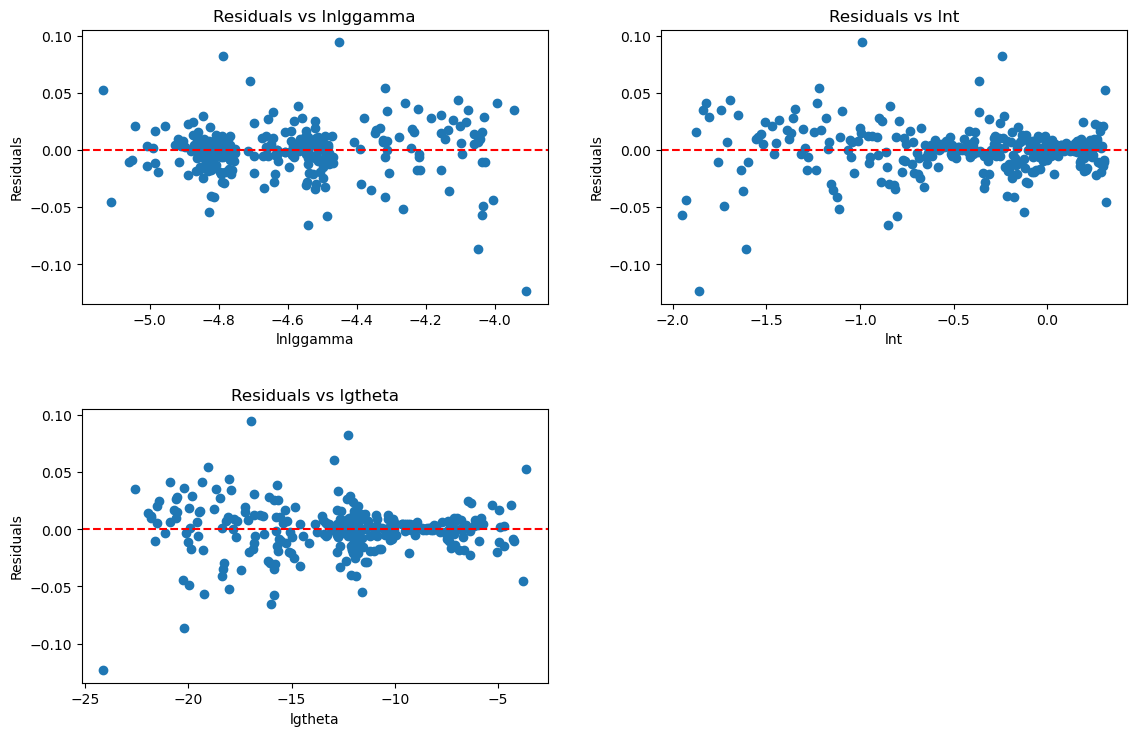

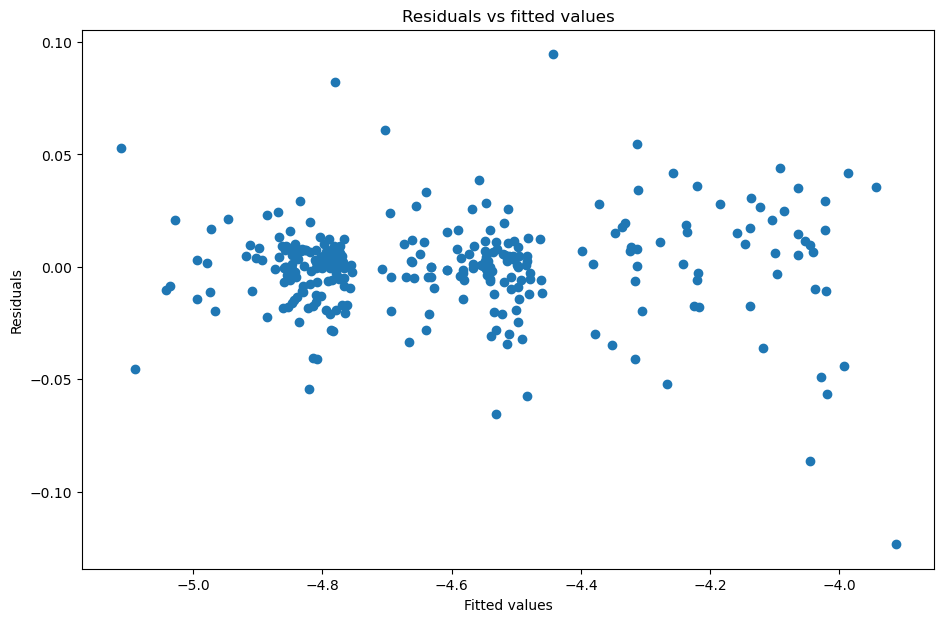

In [300]:
X = X.drop(columns=['lgprix'])
X_train = X_train.drop(columns=['lgprix'])
X_test = X_test.drop(columns=['lgprix'])
print(X_train, X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

# Function to fit a model and return AIC, BIC, and R²
def fit_model_and_evaluate(X_train, y_train, X_test, y_test, showpvalues):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    fitted_values = model.predict(X_train)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print('MSE', mse)
    
    X_train_sm = sm.add_constant(X_train)  # Adds a constant term to the predictor
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    aic = model_sm.aic
    bic = model_sm.bic
    sigma_hat = np.sqrt(model_sm.mse_resid)
    print("SIGMA HAT = ", sigma_hat)  
    residuals = y_test - y_pred
    residualstrain = y_train - fitted_values
    if showpvalues:
        pvalues = model_sm.pvalues
        print(pvalues)
        plt.figure(figsize=(12, 8))
        for i, feature in enumerate(X_train.columns):
            plt.subplot(2, 2, i+1)
            plt.scatter(X_train[feature], residualstrain)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel(feature)
            plt.ylabel('Residuals')
            plt.title(f'Residuals vs {feature}')
            plt.tight_layout(pad=3.0)
        plt.figure(figsize=(11, 7))
        plt.scatter(fitted_values, residualstrain)
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.title(f'Residuals vs fitted values')
    
    coefs = list()
    coefs.append(model.intercept_)
    print(model.intercept_)    
    print("Regression Coefficients:")
    for feature, coef in zip(X_train.columns, model.coef_):
        print(f"{feature}: {coef}")
        coefs.append(coef)
        
        
    
    return aic, bic, r2, coefs

# Initial model with all features
initial_aic, initial_bic, initial_r2, coefs = fit_model_and_evaluate(X_train, y_train, X_test, y_test, True)
print(f'Initial model AIC: {initial_aic}, BIC: {initial_bic}, R²: {initial_r2}')

# Evaluate models by removing one feature at a time
results = []
for feature in X.columns:
    X_train_reduced = X_train.drop(columns=[feature])
    X_test_reduced = X_test.drop(columns=[feature])
    aic, bic, r2, coefx = fit_model_and_evaluate(X_train_reduced, y_train, X_test_reduced, y_test, False)
    results.append((feature, aic, bic, r2))

# Find the best model based on AIC, BIC, and R²
best_aic = min(results, key=lambda x: x[1])
best_bic = min(results, key=lambda x: x[2])
best_r2 = max(results, key=lambda x: x[3])

print("\nBest model results after removing one feature:")
print(f"Best AIC: Remove {best_aic[0]}, AIC: {best_aic[1]}, BIC: {best_aic[2]}, R²: {best_aic[3]}")
print(f"Best BIC: Remove {best_bic[0]}, AIC: {best_bic[1]}, BIC: {best_bic[2]}, R²: {best_bic[3]}")
print(f"Best R²: Remove {best_r2[0]}, AIC: {best_r2[1]}, BIC: {best_r2[2]}, R²: {best_r2[3]}")


0.06827240507190038
